### Particle Swarm Optimization

Particle Swarm Optimization is a classic swarm intelligence optimizer governed by simple mathematical formulas. It does not require optimized fuction to be differentiable as it operates solely on evaluations in specific points. This set of exercises introduces PSO, its parameters and applications. The tasks are thematically ordered however, if you get stuck on something, feel free to proceed to the next task and come back later.

Implementation used in this laboratory is based on a library pyswarm:\
https://pythonhosted.org/pyswarm/

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pso(func, lb, ub, cons=[], 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-8, minfunc=1e-8, 
        debug=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    cons : list
        A list of functions of length n such that cons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, the aditional list containing runtime information will be returned. Check the Returns -> all_populations section for more information.
        (Default: False)
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    all_populations : List[List[Tuple[np.ndarray, np.ndarray, float, bool]]]
        List of all individuals represented by tuples (position, velocity, value, feasibility) divided into generation groups. Available in debug mode, otherwise the list is empty
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize constraint check function
    if len(cons) == 0:
        is_feasible = lambda _: True
    else:
        is_feasible = lambda x: np.all([func(x) for func in cons])
        
    # Initialize the particle swarm
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value

    # Initialize population list for debug mode
    all_populations = []
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    for i in range(S):
        fx[i] = func(x[i, :])
        fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)

    # Store population info for debug mode
    if debug:
        current_population = tuple([(x[i], v[i], fx[i], fs[i]) for i in range(S)])
        all_populations.append(current_population)
       
    # Iterate until termination criterion met
    it = 1
    while it <= maxiter:
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        for i in range(S):
            fx[i] = func(x[i, :])
            fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        if debug:
            current_population = tuple([(x[i], v[i], fx[i], fs[i]) for i in range(S)])
            all_populations.append(current_population)

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                return p_min, fp[i_min], all_populations
                    
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                return p_min, fp[i_min], all_populations
                    
            else:
                g = p_min.copy()
                fg = fp[i_min]
        
        # Update the particles velocities
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)

        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    return g, fg, all_populations

### Task 1
Test the newly learned tool on the two benchmark functions below in 3 dimensions.

In [3]:
def rastrigin_gen(dim):
    return lambda x: 10*dim + np.sum([xi*xi - 10*np.cos(2*np.pi*xi) for xi in x])

def shwefel_gen(dim):
    return lambda x: 418.9829*dim - np.sum([xi * np.sin(np.sqrt(np.abs(xi))) for xi in x])

In [4]:
dimensions = 3

rastrigin_3 = rastrigin_gen(3)
shwefel_3 = shwefel_gen(3)

rastrigin_lb = [-5.12]*dimensions
rastrigin_ub = [5.12]*dimensions

shwefel_lb = [-500]*dimensions
shwefel_ub = [500]*dimensions

### Task 2
For each of parameters phip, phig and omega test how changing its value influences algorithm behaviour. Compare the algorithm performance over generations by drawing a convergence graph for runs with default and changed values on one of the benchmark functions in 10 dimensions. To do this you will have to access information using debug mode (set specific parameter value).

##### Convergence graph
This graph represents the best achieved fitness value as a function of the number of individuals evaluated. In our case as the population remains constant during experiment you can plot the best fitness per generation. For example a graph may look like this: <br/>
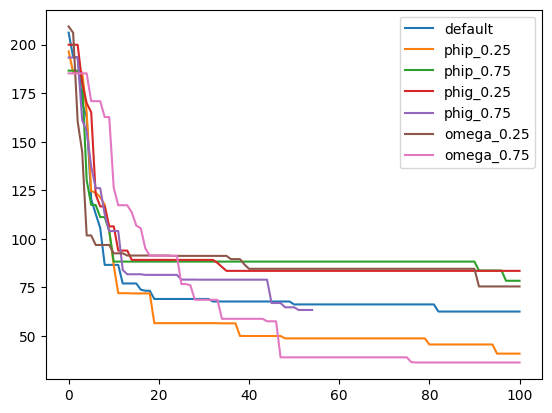

### Task 2*
Remember that the algorithms tested are stochastic in nature so if you want to show meaningful results you should repeat the experiment for a statistically significant number of times. For the sake of excercise let's say that 10 times is enough and calculate average best fitness per generation. If the algorithm terminates before max iteration, you can treat it as staying on its best achieved fitness value for the sake of calculating average over all the runs. Instead of displaying the average best value you can show more statistics by plotting convergence plot made of boxplots.

### Task 3
Now being a Particle Swarm Optimization expert you decide to use your knowledge to solve a real-world engineering task related to hydrocarbon processing. You receive the description as follows:

Maximize:\
f(X) = 0.035 x<sub>1</sub> x<sub>5</sub> + 1.715 x<sub>1</sub> + 10.0 x<sub>2</sub> + 4.0565 x<sub>3</sub> - 0.063 x<sub>3</sub> x<sub>4</sub>

Subject to:\
g<sub>1</sub>(X) = 0.0059553571 x<sub>5</sub><sup>2</sup> x<sub>1</sub> + 0.88392857 x<sub>3</sub> − 0.1175625 x<sub>5</sub> x<sub>1</sub> − x<sub>1</sub> <= 0,\
g<sub>2</sub>(X) = 1.1088 x<sub>1</sub> + 0.1303533 x<sub>1</sub> x<sub>5</sub> − 0.0066033 x<sub>1</sub> x<sub>5</sub><sup>2</sup> − x<sub>3</sub> <= 0,\
g<sub>3</sub>(X) = 6.25 x<sub>1</sub> x<sub>5</sub> + 6.25 x<sub>1</sub> − 7.625 x<sub>3</sub> − 100000 <= 0

With bounds:\
1000 <= x<sub>1</sub> <= 2000,\
0 <= x<sub>2</sub> <= 100,\
2000 <= x<sub>3</sub> <= 4000,\
0 <= x<sub>4</sub> <= 100,\
0 <= x<sub>5</sub> <= 20

Petrochemists that gave you the task say that evaluating it is very expensive so your algorithm can not exceed a budget of 100 000 evaluations.\
Implement this problem and its constraints and optimize it's solution using PSO.

### Task 4

After solving a real life problem in a continuous domain your next goal is to apply PSO for discrete optimization. However, to do that you need to adapt the algorithm to new conditions. To look up how it is done, read a subsection 3.2.1 of a linked review article and implement the functions below. You can also try different approaches listed in the same section.

https://www.researchgate.net/publication/257513040_Particle_swarm_optimisation_for_discrete_optimisation_problems_A_review

Then test your algorithm on a set of discrete problems binary_ones and binary_zeros. As the algorithm changed you will need to experiment to find new effective values for its parameters.

In [1]:
def sigmoid(x):
    pass

def initialize_positions(size):
    pass

def initialize_velocities(size):
    pass

def update_positions(size, velocities):
    pass

In [233]:
def binary_pso(func, genome_length, omega, phip, phig,
        cons=[], swarmsize=100, maxiter=100, no_improv=10, 
        debug=False):
   
    assert hasattr(func, '__call__'), 'Invalid function handle'

    # Initialize constraint check function
    if len(cons) == 0:
        is_feasible = lambda _: True
    else:
        is_feasible = lambda x: np.all([func(x) for func in cons])
        
    # Initialize the particle swarm
    S = swarmsize
    D = genome_length  # the number of dimensions each particle has
    x = initialize_positions((S, D))  # Initialize the particle's position
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value

    no_improvement_counter = 0

    # Initialize population list for debug mode
    all_populations = []

    # Calculate objective and constraints for each particle
    for i in range(S):
        fx[i] = func(x[i, :])
        fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = initialize_velocities((S, D))

    # Store population info for debug mode
    if debug:
        current_population = tuple([(x[i], v[i], fx[i], fs[i]) for i in range(S)])
        all_populations.append(current_population)
       
    # Iterate until termination criterion met
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = update_positions((S, D), v)

        # Update objectives and constraints
        for i in range(S):
            fx[i] = func(x[i, :])
            fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        if debug:
            current_population = tuple([(x[i], v[i], fx[i], fs[i]) for i in range(S)])
            all_populations.append(current_population)

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)

        if fp[i_min] == fg:
            no_improvement_counter += 1
            if no_improvement_counter >= no_improv:
                print('Stopping search: No change in swarm best objective for {:} generations'\
                    .format(no_improv))
                return p[i_min, :], fp[i_min], all_populations
        elif fp[i_min] < fg:
            p_min = p[i_min, :].copy()
            g = p_min.copy()
            fg = fp[i_min]
            no_improvement_counter = 0
        else:
            no_improvement_counter = 0

        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    return g, fg, all_populations

In [1]:
def binary_ones(x):
    return -np.sum(x)

def binary_zeros(x):
    return np.sum(x)

### Task 5

Having obtained the results you want to show the petrochemists, how the PSO works. You conclude that the best way would be to choose some 2-dimensional problem and visualize the particles in several subsequent generations so that you can show the gradual concentration around the optimum. It would be even better if you also visualized velocities. To do that you might use a series of simple scatter plots from matplotlib or try to prepare an animation using matplotlib.animation.ArtistAnimation().